In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from keras.models import Sequential
from keras.layers import Dense, Dropout,GRU
from keras import optimizers 
from sklearn.preprocessing import MinMaxScaler

seed = 1234
np.random.seed(seed)
plt.style.use('ggplot')

Using TensorFlow backend.


# Import Data

In [2]:
dataraw = pd.read_csv('BTC-USD.csv',index_col='Date', parse_dates=['Date'])
dataraw
dataraw.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03
mean,4185.932266,4294.749473,4069.363555,4190.018268,4190.018268,7.431161e+09
std,4029.791354,4152.358417,3886.728318,4030.549406,4030.549406,1.144642e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,425.334488,432.388504,420.620514,424.749496,424.749496,5.841410e+07
50%,3341.840088,3453.449951,3247.669922,3378.939941,3378.939941,1.537460e+09
75%,7509.315185,7696.606445,7374.902588,7531.821777,7531.821777,1.004265e+10
max,19475.800780,20089.000000,18974.099610,19497.400390,19497.400390,7.415677e+10


# Feature Selection

 Count row of data:  2123


D:\application\Anaconda\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


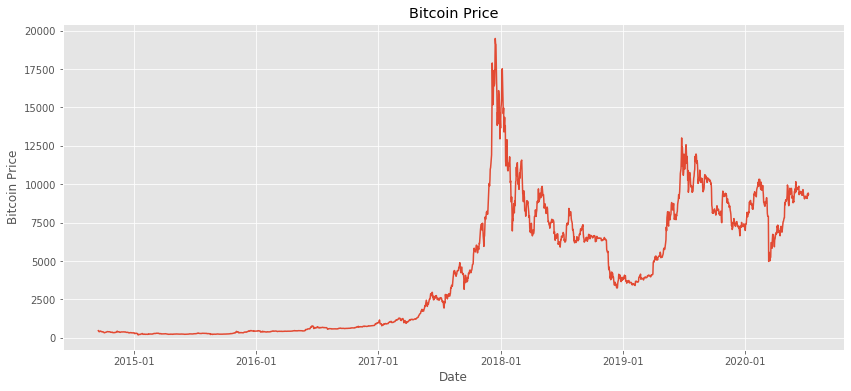

In [3]:
# use feature 'Date' & 'Close'
dataset = pd.DataFrame(dataraw['Close'])
print(' Count row of data: ',len(dataset))

fig = plt.figure(figsize=(14, 6))
plt.plot(dataset)
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Bitcoin Price')
plt.show()

# Preprocessing Data

### Normalization Min-Max

In [4]:
#Min-Max Normalization
dataset_norm = dataset.copy()
dataset[['Close']]
scaler = MinMaxScaler()
dataset_norm['Close'] = scaler.fit_transform(dataset[['Close']])
dataset_norm

,Close
Date,
2014-09-17,0.014453
2014-09-18,0.012751
2014-09-19,0.011216
2014-09-20,0.011947
2014-09-21,0.011425
...,...
2020-07-05,0.460464
2020-07-06,0.476072
2020-07-07,0.469695


### Graph Data Normalized

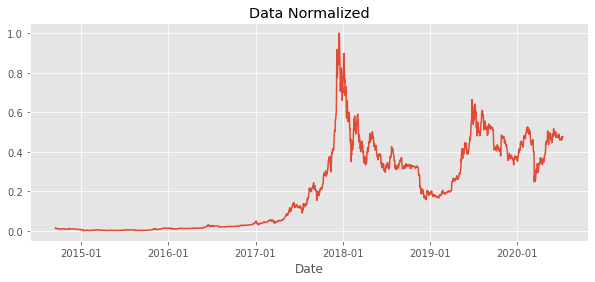

In [5]:
fig = plt.figure(figsize=(10, 4))
plt.plot(dataset_norm)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Normalized')
plt.show()

# Data Partition

In [6]:
# Partition data into data train, val & test
totaldata = dataset.values
totaldatatrain = int(len(totaldata)*0.7)
totaldataval = int(len(totaldata)*0.1)
totaldatatest = int(len(totaldata)*0.2)

# Store data into each partition
training_set = dataset_norm[0:totaldatatrain]
val_set=dataset_norm[totaldatatrain:totaldatatrain+totaldataval]
test_set = dataset_norm[totaldatatrain+totaldataval:]

# Graph Training Data

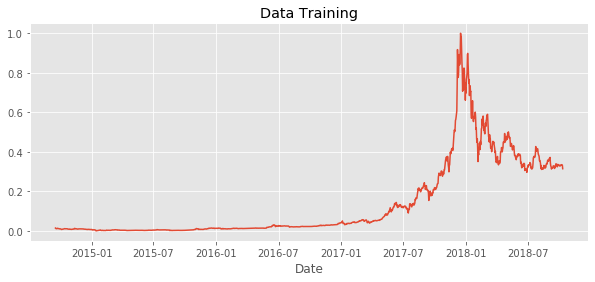

In [7]:
# graph data training
fig = plt.figure(figsize=(10, 4))
plt.plot(training_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Training')
plt.show()

# Grafik Data Validation

,Close
Date,
2018-10-12,0.315564
2018-10-13,0.316155
2018-10-14,0.316410
2018-10-15,0.332229
2018-10-16,0.332207
...,...
2019-05-07,0.292526
2019-05-08,0.300443
2019-05-09,0.310385


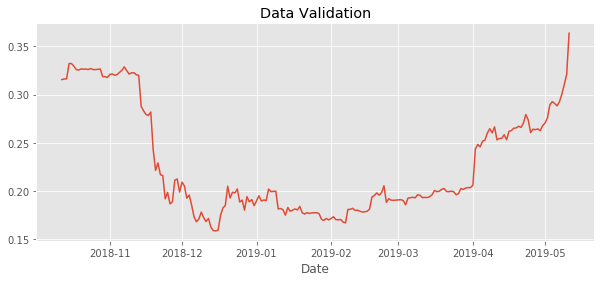

In [8]:
# graph data validation
fig = plt.figure(figsize=(10, 4))
plt.plot(val_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Validation')
val_set

# Grafik Data Test

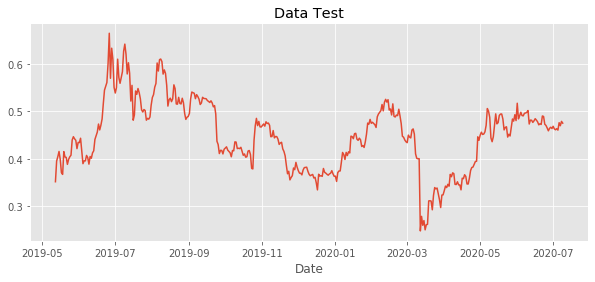

,Close
Date,
2019-05-12,0.351683
2019-05-13,0.395295
2019-05-14,0.404586
2019-05-15,0.415495
2019-05-16,0.398918
...,...
2020-07-05,0.460464
2020-07-06,0.476072
2020-07-07,0.469695


In [9]:
# graph data test
fig = plt.figure(figsize=(10, 4))
plt.plot(test_set)
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.title('Data Test')
plt.show()
test_set

# Sliding Windows

In [10]:
# Initiaton value of lag
lag = 2
# sliding windows function
def create_sliding_windows(data,len_data,lag):
    x=[]
    y=[]
    for i in range(lag,len_data):
        x.append(data[i-lag:i,0])
        y.append(data[i,0]) 
    return np.array(x),np.array(y)

# Formating data into array for create sliding windows
array_training_set = np.array(training_set)
array_val_set = np.array(val_set)
array_test_set = np.array(test_set)

# Create sliding windows into training data
x_train, y_train = create_sliding_windows(array_training_set,len(array_training_set), lag)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
# Create sliding windows into validation data
x_val,y_val = create_sliding_windows(array_val_set,len(array_val_set),lag)
x_val = np.reshape(x_val, (x_val.shape[0],x_val.shape[1],1))
# Create sliding windows into test data
x_test,y_test = create_sliding_windows(array_test_set,len(array_test_set),lag)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

# Model GRU

In [11]:
# Hyperparameters
learning_rate = 0.0001
hidden_unit = 64
batch_size=256
epoch = 100

# Architecture Gated Recurrent Unit
regressorGRU = Sequential()

# First GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, input_shape=(x_train.shape[1],1), activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=True, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer with dropout
regressorGRU.add(GRU(units=hidden_unit, return_sequences=False, activation = 'tanh'))
regressorGRU.add(Dropout(0.2))

# Output layer
regressorGRU.add(Dense(units=1))

# Compiling the Gated Recurrent Unit
regressorGRU.compile(optimizer=optimizers.adam(lr=learning_rate),loss='mean_squared_error')

# Fitting ke data training dan data validation
pred = regressorGRU.fit(x_train, y_train, validation_data=(x_val,y_val), batch_size=batch_size, epochs=epoch)

Train on 1484 samples, validate on 210 samples
Epoch 1/100
1484/1484 [==============================] - 9s 6ms/step - loss: 0.0556 - val_loss: 0.0495
Epoch 2/100
1484/1484 [==============================] - 0s 207us/step - loss: 0.0519 - val_loss: 0.0445
Epoch 3/100
1484/1484 [==============================] - 0s 222us/step - loss: 0.0480 - val_loss: 0.0398
Epoch 4/100
1484/1484 [==============================] - 0s 222us/step - loss: 0.0446 - val_loss: 0.0352
Epoch 5/100
1484/1484 [==============================] - 0s 219us/step - loss: 0.0416 - val_loss: 0.0307
Epoch 6/100
1484/1484 [==============================] - 0s 245us/step - loss: 0.0381 - val_loss: 0.0266
Epoch 7/100
1484/1484 [==============================] - 0s 217us/step - loss: 0.0353 - val_loss: 0.0226
Epoch 8/100
1484/1484 [==============================] - 0s 268us/step - loss: 0.0326 - val_loss: 0.0189
Epoch 9/100
1484/1484 [==============================] - 0s 218us/step - loss: 0.0297 - val_loss: 0.0155
Epoch 10/1

1484/1484 [==============================] - 0s 313us/step - loss: 9.8545e-04 - val_loss: 1.4268e-04
Epoch 76/100
1484/1484 [==============================] - 0s 305us/step - loss: 9.5620e-04 - val_loss: 1.4893e-04
Epoch 77/100
1484/1484 [==============================] - 0s 244us/step - loss: 0.0011 - val_loss: 1.4476e-04
Epoch 78/100
1484/1484 [==============================] - 0s 259us/step - loss: 0.0011 - val_loss: 1.4167e-04
Epoch 79/100
1484/1484 [==============================] - 0s 301us/step - loss: 0.0011 - val_loss: 1.2102e-04
Epoch 80/100
1484/1484 [==============================] - ETA: 0s - loss: 0.001 - 0s 235us/step - loss: 0.0011 - val_loss: 1.2452e-04
Epoch 81/100
1484/1484 [==============================] - 0s 325us/step - loss: 0.0012 - val_loss: 1.4495e-04
Epoch 82/100
1484/1484 [==============================] - 0s 269us/step - loss: 0.0011 - val_loss: 1.6080e-04
Epoch 83/100
1484/1484 [==============================] - 0s 248us/step - loss: 8.6481e-04 - val_loss

## Graph training loss & validation loss

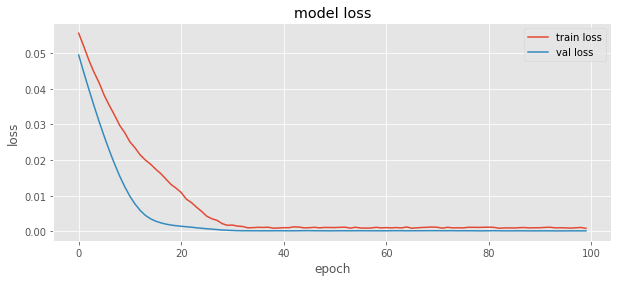

In [12]:
# Graph model loss (train loss & val loss)
fig = plt.figure(figsize=(10, 4))
plt.plot(pred.history['loss'], label='train loss')
plt.plot(pred.history['val_loss'], label='val loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

# Tabel Training Loss & Validation Loss

In [13]:
# Tabel value of training loss & validation loss
learningrate_parameter = learning_rate
train_loss=pred.history['loss'][-1]
validation_loss=pred.history['val_loss'][-1]
learningrate_parameter=pd.DataFrame(data=[[learningrate_parameter, train_loss, validation_loss]],
                                    columns=['Learning Rate', 'Training Loss', 'Validation Loss'])
learningrate_parameter.set_index('Learning Rate')

,Training Loss,Validation Loss
Learning Rate,,
0.0001,0.000828,0.000129


# Implementation model into data test

In [14]:
# Implementation model into data test
y_pred_test = regressorGRU.predict(x_test)

# Invert normalization min-max
y_pred_invert_norm = scaler.inverse_transform(y_pred_test)


# Comparsion data test with prediction results

In [23]:
# Comparision data test with data prediction
datacompare = pd.DataFrame()
datatest=np.array(dataset['Close'][totaldatatrain+totaldataval+lag:])
datapred= y_pred_invert_norm

datacompare['Data Test'] = datatest
datacompare['Prediction Results'] = datapred
datacompare

,Data Test,Prediction Results
0,7994.416016,7100.946777
1,8205.167969,7735.155762
2,7884.909180,7924.944824
3,7343.895508,7968.740234
4,7271.208008,7578.303223
...,...,...
418,9073.942383,8971.585938
419,9375.474609,8984.197266
420,9252.277344,9039.548828
421,9428.333008,9208.788086


## Evaluasi Hasil Prediksi

In [21]:
# Calculatre value of Root Mean Square Error 
def rmse(datatest, datapred):
    return np.round(np.sqrt(np.mean((datapred - datatest) ** 2)), 4)
print('Result Root Mean Square Error Prediction Model :',rmse(datatest, datapred))

def mape(datatest, datapred): 
    return np.round(np.mean(np.abs((datatest - datapred) / datatest) * 100), 4)
    
print('Result Mean Absolute Percentage Error Prediction Model : ', mape(datatest, datapred), '%')

Result Root Mean Square Error Prediction Model : 1994.7004
Result Mean Absolute Percentage Error Prediction Model :  18.5992 %


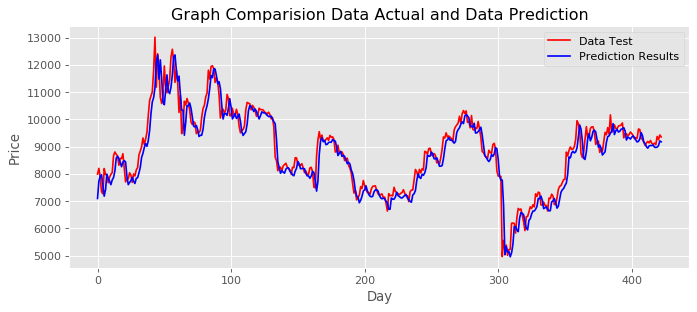

In [22]:
# Create graph data test and prediction result
plt.figure(num=None, figsize=(10, 4), dpi=80,facecolor='w', edgecolor='k')
plt.title('Graph Comparision Data Actual and Data Prediction')
plt.plot(datacompare['Data Test'], color='red',label='Data Test')
plt.plot(datacompare['Prediction Results'], color='blue',label='Prediction Results')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.show()
